In [42]:
import os,sys,inspect
currentdir = "D:/BAMT/plan/big_cluster"
# parentdir = os.path.dirname(currentdir)
parentdir = "D:/BAMT"
sys.path.insert(0,parentdir)

In [43]:
import pandas as pd
import random
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign

from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from copy import copy
from visualization.visualization import draw_BN, draw_comparative_hist, get_probability
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from core.core_utils import project_root
from external.pyBN.utils.independence_tests import mutual_information, entropy, mi_from_en
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
import seaborn as sns
import sklearn.metrics as skm
import scipy.stats as ss
from scipy.spatial.distance import cdist
from external.libpgm.sampleaggregator import SampleAggregator
from sklearn.metrics import accuracy_score, mean_squared_error
import operator
from typing import Tuple
import json
from bayesian.sampling import generate_synthetics
from graph.precision_recall import child_dict
from visualization.visualization import get_probability, grouped_barplot
from bayesian.calculate_accuracy import parall_accuracy

In [44]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [45]:
data = pd.read_csv(f'{project_root()}/data/mehra.csv')
data.reset_index(drop=True, inplace=True)
print(set(data.dtypes))
print(data.columns[data.dtypes == 'int64'])
print(data.columns[data.dtypes == 'float64'])
print(data.columns[data.dtypes == 'object'])

{dtype('int64'), dtype('float64'), dtype('O')}
Index(['Year', 'Month', 'Day', 'Hour'], dtype='object')
Index(['Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'],
      dtype='object')
Index(['Region', 'Zone', 'Type', 'Season'], dtype='object')


In [46]:
print(data.columns)

Index(['Region', 'Zone', 'Type', 'Year', 'Season', 'Month', 'Day', 'Hour',
       'Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5'],
      dtype='object')


In [47]:
boarders = [1, 50, 100]
interesting = {}
for var in list(data.columns):
    count = len(set(data[var].values))
    if (count> boarders[1]):
        if data[var].dtype == 'O':
            print(var)
        interesting[var] = count
sorted_tuples = sorted(interesting.items(), key=lambda item: item[1])
sorted_dict = {k: v for k, v in sorted_tuples}
sorted_dict


{'Latitude': 10000,
 'Longitude': 10000,
 'Altitude': 10000,
 't2m': 10000,
 'ws': 10000,
 'wd': 10000,
 'tp': 10000,
 'blh': 10000,
 'ssr': 10000,
 'CVD60': 10000,
 'no2': 10000,
 'o3': 10000,
 'so2': 10000,
 'co': 10000,
 'pm10': 10000,
 'pm2.5': 10000}

In [48]:
# boarder = 50
# interesting = {}
# for var in list(data.columns):
#     count = len(set(data[var].values))
#     if (count> boarder):
#         data[var] = data[var].apply(lambda x: float(x))
#     else:
#         data[var] = data[var].apply(lambda x: str(x))
# #data['city_id'] = data['city_id'].apply(lambda x: int(x)).apply(lambda x: str(x))


In [49]:
col_inter = ['Region', 'Zone', 'Type', 'Year', 'Season', 'Month', 'Day', 'Hour',
       'Latitude', 'Longitude', 'Altitude', 't2m', 'ws', 'wd', 'tp', 'blh',
       'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5']

In [50]:
data=data[col_inter]

In [51]:
data.head()

,Region,Zone,Type,Year,Season,Month,Day,Hour,Latitude,Longitude,...,tp,blh,ssr,CVD60,no2,o3,so2,co,pm10,pm2.5
0,Yorkshire and The Humber,West Midlands Urban Area,Background Urban,1988,Winter,3,26,9,52.829361,-1.726818,...,0.000784,992.501830,5.133717e+05,0.205020,61.974631,17.740408,13.813847,1.442624,36.486336,18.646589
1,North West,Greater London Urban Area,Background Rural,1995,Spring,8,2,19,51.377194,-2.745956,...,0.000130,1086.774403,1.149178e+07,0.246176,83.165539,32.657576,22.427120,1.273507,34.964375,18.643421
2,West Midlands,North West & Merseyside,Background Urban,1997,Spring,3,14,4,52.002869,-2.760588,...,0.000209,683.612000,-1.076695e+01,0.181319,76.460115,17.692036,13.803708,1.442563,36.458572,18.645740
3,South East,Greater London Urban Area,Traffic Urban,1994,Winter,3,3,18,54.061788,-2.439756,...,0.000996,1252.022401,3.290441e+06,0.201057,85.786023,17.749945,26.277995,1.793299,36.543445,18.641970
4,South East,Greater London Urban Area,Background Urban,1997,Fall,8,15,18,54.570412,-1.460727,...,-0.000691,1730.349463,8.348839e+06,0.175219,48.424476,83.015267,-0.018112,0.359330,38.317914,18.640665


In [52]:
data['Month'] = data['Month'].apply(str)
data['Day'] = data['Day'].apply(str)
data['Hour'] = data['Hour'].apply(str)

In [53]:
if 'Onshore/offshore' in data.columns:
    data.rename({'Onshore/offshore': 'OnshoreOffshore'}, axis = 1, inplace = True)

In [54]:
print(len(data))

10000


In [55]:
data = data.dropna()

In [56]:
print(len(data))

10000


In [57]:
data = data.sample(n=400, random_state=1)

In [58]:
"""small_columns = []
for var in data_types:
    if data_types[var] != 'disc':
        if data[var].max()-data[var].min() < 1.0:
            small_columns.append(var)
data.drop(small_columns, axis=1, inplace=True)"""

"small_columns = []\nfor var in data_types:\n    if data_types[var] != 'disc':\n        if data[var].max()-data[var].min() < 1.0:\n            small_columns.append(var)\ndata.drop(small_columns, axis=1, inplace=True)"

In [59]:
data_types = get_nodes_type(data)

In [60]:
colums_for_code = []
columns_for_disc = []
for c in data.columns:
    if data_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [61]:
data_types

{'Region': 'disc',
 'Zone': 'disc',
 'Type': 'disc',
 'Year': 'disc',
 'Season': 'disc',
 'Month': 'disc',
 'Day': 'disc',
 'Hour': 'disc',
 'Latitude': 'cont',
 'Longitude': 'cont',
 'Altitude': 'cont',
 't2m': 'cont',
 'ws': 'cont',
 'wd': 'cont',
 'tp': 'cont',
 'blh': 'cont',
 'ssr': 'cont',
 'CVD60': 'cont',
 'no2': 'cont',
 'o3': 'cont',
 'so2': 'cont',
 'co': 'cont',
 'pm10': 'cont',
 'pm2.5': 'cont'}

In [62]:
data_coded, label_coder = code_categories(data, 'label', colums_for_code)
data_discrete, coder = discretization(data_coded, 'equal_frequency', columns_for_disc)

In [63]:
def su_dist(x, y): 
    #print(x)
    #print(y)
    #z = np.concatenate((np.array(x).reshape(-1, 1), np.array(y).reshape(-1, 1)), axis=1)
    #z = np.concatenate((x, y), axis=1)
    """if (entropy(x) + entropy(y)) == 0.0:
        print(mi_from_en(z))
        return 0.0
    else:
        return - 2 * mi_from_en(z) / (entropy(x) + entropy(y))"""
    return 1.0 - normalized_mutual_info_score(x, y)

In [64]:
column = list(data.columns)
D = [[0.0 for i in column] for j in column]
for i, var1 in enumerate(column):
    for j, var2 in enumerate(column):
        D[i][j] = su_dist(data_discrete[var1].values, data_discrete[var2].values)
#D = np.where(np.isnan(D), 0.0, D)    


In [65]:
alpha = 0.8

res_dict = {}


model = AgglomerativeClustering(distance_threshold=alpha, n_clusters=None, affinity='precomputed', linkage='single')
model = model.fit_predict(D)

for i, val in enumerate(model):
    if val in res_dict:
        res_dict[val].append(column[i])
    else:
        res_dict[val] = [column[i]]
for key, val in res_dict.items():
    if len(val) > 1:
        print(val)

['Zone', 'Year', 'Day', 'Hour']
['Month', 't2m']


In [66]:
"""linkage_matrix = linkage(D, "single")
dendrogram(linkage_matrix, labels=column)
plt.title("test")
plt.show()"""

'linkage_matrix = linkage(D, "single")\ndendrogram(linkage_matrix, labels=column)\nplt.title("test")\nplt.show()'

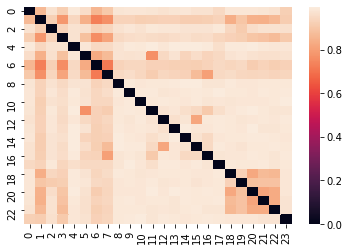

In [67]:
ax = sns.heatmap(D)

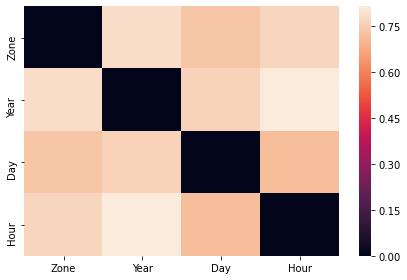

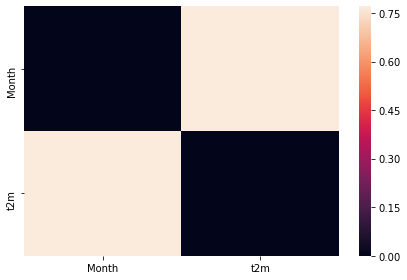

In [68]:
label_dict = {var: var for var in column}
label_dict['Depositional system'] = 'Dep. sys.'
label_dict['Depositional environment'] = 'Dep. env.'
ind_dict = {}
for i, val in enumerate(model):
    if val in ind_dict:
        ind_dict[val].append(i)
    else:
        ind_dict[val] = [i]
count = 0
for key, val in ind_dict.items():
    if len(val) > 1:
        count += 1

g = [None for _ in range(count)]
ind = 0
for key, val in ind_dict.items():
    if len(val) > 1:
        loc_D = [[D[i][j] for j in val] for i in val]
        fig, ax = plt.subplots()
        ax = sns.heatmap(loc_D, xticklabels=[label_dict[column[i]] for i in val], yticklabels=[label_dict[column[i]] for i in val])
        plt.tight_layout()
        plt.savefig(str([column[i] for i in val]))
        #fig.clear()
        ind += 1

In [69]:
def zip_code(data_discrete: pd.DataFrame, cluster_columns: list, alpha: float = 0.95, low_limit: int = 30):
    group = copy(data_discrete).groupby(cluster_columns)
    comb = group.size().reset_index().rename(columns={0:'count'})
    comb['count'] = comb['count'] / len(data_discrete)
    comb.sort_values(by=['count'], inplace=True, ascending=False)
    sum = 0.0
    ind = 0
    while (sum < alpha):
        sum += comb.iloc[ind]['count']
        ind += 1
        if ind == len(comb):
            break

    x, _ = code_categories(comb, 'onehot', cluster_columns)
    x = x.values
    if ind < len(comb):
        dists = cdist(x[ind:, :], x[:ind, :], metric='hamming')
        neighbors_map = [list(np.where(row == row.min())[0]) for row in dists]
        neighbors_map = [args[-1] for args in neighbors_map]
        better = [i if (i < ind) else neighbors_map[i - ind] for i in range(len(comb))]
    else:
        better = [i for i in range(len(comb))]

    code_col = [None for _ in range(len(data_discrete))]
    for i in range(len(comb)):
        merged_values = tuple(comb[cluster_columns].iloc[i])
        for j in group.indices[merged_values]:
            code_col[j] = better[i]

    return code_col

In [70]:
df2 = pd.DataFrame()
for key, val in res_dict.items():
    if len(val) > 1:
        code_col = zip_code(data_discrete, val)
        df2[tuple(val)] = code_col
    else:
        df2[tuple(val)] = data_discrete[val[0]]

In [71]:
tuple_columns = df2.columns
rename_dict = {tuple_columns[i]: i  for i in range(len(tuple_columns))}
df2.rename(rename_dict, axis = 1, inplace=True)
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,120,2,1,9,3,0,0,3,2,2,2,2,1,0,0,4,0,0,4
1,1,19,0,1,7,3,4,4,3,2,1,3,4,1,3,0,3,3,4,2
2,3,365,2,1,14,0,2,2,0,2,3,1,0,3,2,1,3,4,3,1
3,1,199,2,3,3,3,3,4,3,4,2,2,3,0,0,2,3,1,4,4
4,1,262,5,3,12,3,2,2,0,1,1,0,0,1,2,1,1,3,1,1


In [72]:
bn_without = structure_learning(data_discrete, 'HC', get_nodes_type(data), 'BIC', cont_disc = False)

In [82]:
print(bn_without['E'])

[['Type', 'Region'], ['Type', 'Zone'], ['Month', 'Zone'], ['Region', 'Zone'], ['Zone', 'Year'], ['Month', 'Year'], ['Region', 'Year'], ['Type', 'Season'], ['Region', 'Season'], ['Type', 'Month'], ['Region', 'Month'], ['Season', 'Month'], ['Zone', 'Day'], ['Hour', 'Day'], ['Year', 'Day'], ['Zone', 'Hour'], ['Month', 'Hour'], ['Year', 'Hour'], ['Zone', 'Latitude'], ['Day', 'Latitude'], ['Hour', 'Latitude'], ['Zone', 'Longitude'], ['Day', 'Longitude'], ['Hour', 'Longitude'], ['Zone', 'Altitude'], ['Day', 'Altitude'], ['Hour', 'Altitude'], ['Zone', 't2m'], ['Day', 't2m'], ['Hour', 't2m'], ['Zone', 'ws'], ['Day', 'ws'], ['Hour', 'ws'], ['Zone', 'wd'], ['Day', 'wd'], ['Hour', 'wd'], ['Zone', 'tp'], ['Day', 'tp'], ['Hour', 'tp'], ['Zone', 'blh'], ['Day', 'blh'], ['Hour', 'blh'], ['Zone', 'ssr'], ['Day', 'ssr'], ['Hour', 'ssr'], ['Zone', 'CVD60'], ['Day', 'CVD60'], ['Hour', 'CVD60'], ['Zone', 'no2'], ['Day', 'no2'], ['Hour', 'no2'], ['Zone', 'o3'], ['Day', 'o3'], ['Hour', 'o3'], ['Zone', 'so2'

In [ ]:
draw_BN(bn_without, {var: 'disc' for var in bn_without['V']}, f'rename_mehra_' + 'full')

In [74]:
node_type = {}
for key, val in rename_dict.items():
    if len(key) > 1:
        node_type[val] = 'dict'
    else:
        node_type[val] = data_types[key[0]]
    

In [75]:
node_type

{0: 'disc',
 1: 'dict',
 2: 'disc',
 3: 'disc',
 4: 'dict',
 5: 'cont',
 6: 'cont',
 7: 'cont',
 8: 'cont',
 9: 'cont',
 10: 'cont',
 11: 'cont',
 12: 'cont',
 13: 'cont',
 14: 'cont',
 15: 'cont',
 16: 'cont',
 17: 'cont',
 18: 'cont',
 19: 'cont'}

In [76]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2,120,2,1,9,3,0,0,3,2,2,2,2,1,0,0,4,0,0,4
1,1,19,0,1,7,3,4,4,3,2,1,3,4,1,3,0,3,3,4,2
2,3,365,2,1,14,0,2,2,0,2,3,1,0,3,2,1,3,4,3,1
3,1,199,2,3,3,3,3,4,3,4,2,2,3,0,0,2,3,1,4,4
4,1,262,5,3,12,3,2,2,0,1,1,0,0,1,2,1,1,3,1,1


In [77]:
bn = structure_learning(df2, 'HC', node_type, 'BIC', cont_disc = False)

In [78]:
rerename_dict = {val: str(key) for key, val in rename_dict.items()}
bn_rename = copy(bn)
bn_rename['V'] = [rerename_dict[var] for var in bn_rename['V']]
bn_rename['E'] = [[rerename_dict[var1], rerename_dict[var2]]  for var1, var2 in bn_rename['E']]

In [79]:
#draw_BN(bn_rename, {rerename_dict[key]: val for key, val in node_type.items()}, 'coded_vars')

In [80]:
bn_dict = dict()
for key, val in res_dict.items():
    if len(val) > 1:
        bn_loc = structure_learning(data_discrete[val], 'HC', {key_t: val_t for key_t, val_t in data_types.items() if key_t in val}, 'BIC', cont_disc = True)
        bn_dict[str(tuple(val))] = bn_loc
#bn_dict

In [81]:
for key, val in res_dict.items():
    if len(val) > 1:
        bn_loc = copy(bn_dict[str(tuple(val))])
        bn_loc['V'] = [rerename_dict_new[var] for var in bn_loc['V']]
        bn_loc['E'] = [[rerename_dict_new[var1], rerename_dict_new[var2]]  for var1, var2 in bn_loc['E']]
        draw_BN(bn_loc, {var: 'disc' for var in bn_loc['V']}, f'rename_mehra_' + str(bn_loc['V']))

NameError: name 'rerename_dict_new' is not defined

In [83]:
bn_full = copy(bn_rename)
for key, bn_loc in bn_dict.items():
    bn_full['V'].extend(bn_loc['V'])
    bn_full['V'].remove(key)
    bn_full['V'].extend([key+"_in", key+'_out'])
    for i in range(len(bn_full['E'])):
        e0, e1 = bn_full['E'][i]
        if e0 == key:
            bn_full['E'][i] = [key+'_out', e1]
        if e1 == key:
            bn_full['E'][i] = [e0, key+'_in']
    bn_full['E'].extend(bn_loc['E'])
    bn_full['E'].extend([[key+'_in', var] for var in bn_loc['V']])
    bn_full['E'].extend([[var, key+'_out'] for var in bn_loc['V']])

In [84]:
#print(bn_full['V'])
rerename_dict_new = dict() 
for var in bn_full['V']:
    if (',)' in var):
        rerename_dict_new[var] = eval(var)[0]
    else:
        rerename_dict_new[var] = var
bn_full_rename = copy(bn_full)
bn_full_rename['V'] = [rerename_dict_new[var] for var in bn_full_rename['V']]
bn_full_rename['E'] = [[rerename_dict_new[var1], rerename_dict_new[var2]]  for var1, var2 in bn_full_rename['E']]
print(bn_full_rename['V'])

['Region', 'Type', 'Season', 'Latitude', 'Longitude', 'Altitude', 'ws', 'wd', 'tp', 'blh', 'ssr', 'CVD60', 'no2', 'o3', 'so2', 'co', 'pm10', 'pm2.5', 'Zone', 'Year', 'Day', 'Hour', "('Zone', 'Year', 'Day', 'Hour')_in", "('Zone', 'Year', 'Day', 'Hour')_out", 'Month', 't2m', "('Month', 't2m')_in", "('Month', 't2m')_out"]


In [85]:
print(bn_full_rename['E'])

[['Type', 'Region'],
 ['Type', "('Zone', 'Year', 'Day', 'Hour')_in"],
 ['Region', "('Zone', 'Year', 'Day', 'Hour')_in"],
 ['Latitude', "('Zone', 'Year', 'Day', 'Hour')_in"],
 ["('Month', 't2m')_out", 'Season'],
 ["('Zone', 'Year', 'Day', 'Hour')_out", 'Season'],
 ['Region', 'Season'],
 ['Type', "('Month', 't2m')_in"],
 ["('Zone', 'Year', 'Day', 'Hour')_out", "('Month', 't2m')_in"],
 ['Region', "('Month', 't2m')_in"],
 ['Type', 'Latitude'],
 ['Region', 'Latitude'],
 ["('Month', 't2m')_out", 'Longitude'],
 ["('Zone', 'Year', 'Day', 'Hour')_out", 'Longitude'],
 ['Region', 'Longitude'],
 ["('Month', 't2m')_out", 'Altitude'],
 ["('Zone', 'Year', 'Day', 'Hour')_out", 'Altitude'],
 ['Region', 'Altitude'],
 ["('Month', 't2m')_out", 'ws'],
 ["('Zone', 'Year', 'Day', 'Hour')_out", 'ws'],
 ['Region', 'ws'],
 ["('Month', 't2m')_out", 'wd'],
 ["('Zone', 'Year', 'Day', 'Hour')_out", 'wd'],
 ['Region', 'wd'],
 ["('Month', 't2m')_out", 'tp'],
 ["('Zone', 'Year', 'Day', 'Hour')_out", 'tp'],
 ['Region',

In [ ]:
draw_BN(bn_full_rename, {var: 'disc' for var in bn_full_rename['V']}, f'rename_mehra_' + 'coded_full')

In [87]:
rename_dict = {str(key): val for key, val in rename_dict.items()}

In [88]:
#data_add = copy(data)
data_add = copy(data_discrete)
for key in bn_full_rename['V']:
    if ')_in' in key:
        data_add[key] = df2[rename_dict[key[:-3]]]
    if ')_out' in key:
        data_add[key] = df2[rename_dict[key[:-4]]]
        

In [89]:
print(len(data.columns))

24


In [90]:
rename_again = {var: str(i) for i, var in enumerate(data_add.columns)}
#rename_again

In [91]:
rename_again_inv = {i: var for var, i in rename_again.items()}

In [92]:
data_add.rename(rename_again, axis=1, inplace=True)
data_add.head()
        

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,2,28,2,11,1,5,26,12,3,0,...,0,0,4,0,0,4,120,120,9,9
1,1,16,0,0,1,8,29,13,3,4,...,3,0,3,3,4,2,19,19,7,7
2,3,8,2,3,1,1,9,1,0,2,...,2,1,3,4,3,1,365,365,14,14
3,1,9,2,10,3,10,8,15,3,3,...,0,2,3,1,4,4,199,199,3,3
4,1,3,5,2,3,9,5,20,3,2,...,2,1,1,3,1,1,262,262,12,12


In [93]:
bn_full_rename_again = copy(bn_full_rename)
bn_full_rename_again['V'] = [rename_again[var] for var in bn_full_rename['V']]
bn_full_rename_again['E'] = [[rename_again[var1], rename_again[var2]]  for var1, var2 in bn_full_rename['E']]
#bn_full_rename_again
        

In [94]:
nodes_loc_net = {}
full_net = copy(bn_full_rename_again)
for var in full_net['V']:
    if ')_' not in rename_again_inv[var]:
        nodes_loc_net[var] = {'V': [var], 'E': []}
        nodes_loc = set([var])
        for e0, e1 in full_net['E']:
            if e1 == var:
                nodes_loc_net[var]['E'].append([e0, e1])
                nodes_loc.add(e0)
                if (')_out' in rename_again_inv[e0]) or (')_in' in rename_again_inv[e0]):
                    for e2, e3 in full_net['E']:
                        if (e3 == e0) and (e2 != var):
                            nodes_loc_net[var]['E'].append([e2, e3])
                            nodes_loc.add(e2)
        
        nodes_loc_net[var]['V'] = list(nodes_loc)
#print(nodes_loc_net)




In [95]:
for key, val in nodes_loc_net.items():  
    draw_BN(val, {var: 'disc' for var in val['V']}, f'local_net_for_{rename_again_inv[key]}')

In [96]:
save_structure(bn_full_rename, 'coded_vars_full_geo_net')

In [97]:
#draw_BN(bn_full_rename, {var: 'disc' for var in bn_full_rename['V']}, 'coded_full_net')

In [98]:
example = dict()
example['V'] = ["('parent_sum', 'is_parent')_in", "('parent_sum', 'is_parent')_out", 'parent_sum', 'is_parent']
example['E'] = [["('parent_sum', 'is_parent')_in", 'is_parent'], ["('parent_sum', 'is_parent')_in", 'parent_sum'], ['is_parent', 'parent_sum'],
 ['parent_sum', "('parent_sum', 'is_parent')_out"], ['is_parent', "('parent_sum', 'is_parent')_out"] ]
#draw_BN(example, {var: 'disc' for var in example['V']}, 'example_block')

In [99]:
nodes_type_add = get_nodes_type(data_add)

In [100]:
ind = 1 
nodes_loc_param = {}
for key, val in nodes_loc_net.items():
    if any([')_' in rename_again_inv[var] for var in val['V']]):
        try:
            params = parameter_learning(data_add[val['V']], {key1: val1 for key1, val1 in nodes_type_add.items() if key1 in val['V']}, val, 'simple', 'kNN')
            nodes_loc_param[key] = params
            save_params(params, f'coded_vars_full_param_{rename_again_inv[key]}')
            print('success')
        except:
            print(ind)
            ind += 1


In [ ]:
key = 'has_pets'
rename_key = rename_again[key]
save_structure(nodes_loc_net[rename_key], f'coded_vars_full_net_{key}')
skelet = read_structure(f'coded_vars_full_net_{key}')
params = read_params(f'coded_vars_full_param_{key}')
bn_h = HyBayesianNetwork(skelet, params)
sample1 = generate_synthetics(bn_h, get_nodes_sign(data_add[nodes_loc_net[rename_key]['V']]), 'simple', 200)

KeyError: 'has_pets'

In [ ]:
sample1[[rename_key]].head()

,49
0,0
1,1
2,0
3,1
4,1


In [ ]:
data_add[[rename_key]].head()

,49
0,0
1,0
2,0
3,0
4,0


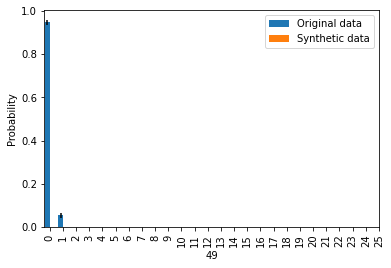

In [ ]:
draw_comparative_hist(rename_key, data_add[[rename_key]], sample1[[rename_key]], {rename_key: 'disc'})

In [ ]:
bn_without_rename_again = copy(bn_without)
bn_without_rename_again['V'] = [rename_again[var] for var in bn_without['V']]
bn_without_rename_again['E'] = [[rename_again[var1], rename_again[var2]]  for var1, var2 in bn_without['E']]

In [ ]:
nodes_without_loc_net = {}
full_net = copy(bn_without_rename_again)
for var in full_net['V']:
    if ')_' not in rename_again_inv[var]:
        nodes_without_loc_net[var] = {'V': [var], 'E': []}
        nodes_loc = set([var])
        for e0, e1 in full_net['E']:
            if e1 == var:
                nodes_without_loc_net[var]['E'].append([e0, e1])
                nodes_loc.add(e0)
                if (')_out' in rename_again_inv[e0]) or (')_in' in rename_again_inv[e0]):
                    for e2, e3 in full_net['E']:
                        if (e3 == e0) and (e2 != var):
                            nodes_without_loc_net[var]['E'].append([e2, e3])
                            nodes_loc.add(e2)
        
        nodes_without_loc_net[var]['V'] = list(nodes_loc)

In [ ]:
for key, val in nodes_without_loc_net.items():  
    draw_BN(val, {var: 'disc' for var in val['V']}, f'local_without_net_for_{rename_again_inv[key]}')

In [ ]:
save_structure(bn_without, 'without_full_geo_net')

In [ ]:
#data_without = copy(data)
data_without = copy(data_coded)
data_without.rename(rename_again, axis=1, inplace=True)
data_without.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,37,5,0,1,5,302575.00,11,7,10,9,8,76.2,56.1,21.0,410.0,2,1,1844.5
1,13,0,2,1,3,13560.30,6,4,16,11,20,227.1,43.9,10.0,8.0,6,40,3134.8
2,13,0,5,1,2,32974.50,14,1,8,15,20,35.1,20.1,22.0,200.0,11,13,3000.9
3,13,0,5,1,2,38902.50,14,4,2,11,20,155.2,125.0,20.0,300.0,11,13,3200.9
4,32,5,0,1,5,33569.77,6,10,30,9,19,76.2,30.5,21.0,60.0,7,34,1510.7


In [ ]:
nodes_type_without = get_nodes_type(data_without)

In [ ]:
ind = 1 
nodes_without_loc_param = {}
for key, val in nodes_without_loc_net.items():
    if key in nodes_loc_param:
        try:
            params = parameter_learning(data_without[val['V']], {key1: val1 for key1, val1 in nodes_type_without.items() if key1 in val['V']}, val, 'simple', 'kNN')
            nodes_without_loc_param[key] = params
            save_params(params, f'without_param_{rename_again_inv[key]}')
            #print('success')
        except:
            print(ind)
            ind += 1

In [ ]:
rename_key

NameError: name 'rename_key' is not defined

In [ ]:
key = 'is_parent'
rename_key = rename_again[key]
save_structure(nodes_without_loc_net[rename_key], f'without_net_{key}')
skelet = read_structure(f'without_net_{key}')
params = read_params(f'without_param_{key}')
bn_h_without = HyBayesianNetwork(skelet, params)
sample1 = generate_synthetics(bn_h_without, get_nodes_sign(data_without[nodes_without_loc_net[rename_key]['V']]), 'simple', 200)

In [ ]:
key = 'is_parent'
rename_key = rename_again[key]
parent = dict()
parent['V'] = [rename_again_inv[var] for var in nodes_without_loc_net[rename_key]['V']]
parent['E'] = []
for e0, e1 in nodes_without_loc_net[rename_key]['E']:
    parent['E'].append([rename_again_inv[e0], rename_again_inv[e1]])


In [ ]:
#draw_BN(parent, {var: 'disc' for var in parent['V']}, f'without_is_parent')

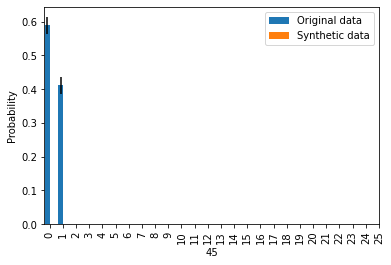

In [ ]:
draw_comparative_hist(rename_key, data_without[nodes_without_loc_net[rename_key]['V']], sample1, {key1: val1 for key1, val1 in nodes_type_without.items() if key1 in nodes_without_loc_net[rename_key]['V']})

In [ ]:
def draw_comparative_hist(parameter: str, original_data: pd.DataFrame,
                          synthetic_data: pd.DataFrame, synthetic_data2: pd.DataFrame,  node_type: dict, rename_again_inv: dict):
    

    if node_type[parameter] == 'disc':
        plt.clf()
        df1 = pd.DataFrame()
        probs = get_probability(sample=original_data, initial_data=original_data,parameter=parameter)

        df1[parameter] = list(probs.keys())

        df1['Probability'] = [p[1] for p in probs.values()]
        df1['Error'] = [p[2] - p[1] for p in probs.values()]
        df1['Data'] = 'Original data'

        df2 = pd.DataFrame()
        probs = get_probability(sample=synthetic_data, initial_data=original_data, parameter=parameter)
        df2[parameter] = list(probs.keys())
        df2['Probability'] = [p[1] for p in probs.values()]
        df2['Error'] = [p[2] - p[1] for p in probs.values()]
        df2['Data'] = 'Clustered'

        df3 = pd.DataFrame()
        probs = get_probability(sample=synthetic_data2, initial_data=original_data, parameter=parameter)
        df3[parameter] = list(probs.keys())
        df3['Probability'] = [p[1] for p in probs.values()]
        df3['Error'] = [p[2] - p[1] for p in probs.values()]
        df3['Data'] = 'Without clustering'

        final_df = pd.concat([df1, df2, df3])

        grouped_barplot(final_df, parameter, 'Data', 'Probability', 'Error')
    # else:
    #     sns.distplot(processor.data[parameter], hist=False, label='Исходные данные')
    #     sns.distplot(data_without_restore[parameter], hist=False, label='Данные из сети с изучаемым узлом')
    #     ax = sns.distplot(data_with_restore[parameter], hist=False, label='Данные из сети без изучаемого узла')
    #     ax.legend()
    
    plt.savefig(f'barplot_{rename_again_inv[parameter]}')
    #plt.show()
    plt.close()

In [ ]:

ind = 1
D_coded = {}
D_without = {}
for key, val in nodes_loc_param.items():
    print(ind / len(nodes_loc_param))
    ind += 1
    try:
        save_structure(nodes_loc_net[key], f'coded_vars_full_net_{rename_again_inv[key]}')
        skelet = read_structure(f'coded_vars_full_net_{rename_again_inv[key]}')
        params = read_params(f'coded_vars_full_param_{rename_again_inv[key]}')
        bn_h = HyBayesianNetwork(skelet, params)
        sample1 = generate_synthetics(bn_h, get_nodes_sign(data_add[nodes_loc_net[key]['V']]), 'simple', 1500)
        D_coded[key] = su_dist(data_add.sample(n=len(sample1), random_state=1)[key].apply(str).values, sample1[key].apply(str).values)

        save_structure(nodes_without_loc_net[key], f'without_net_{rename_again_inv[key]}')
        skelet2 = read_structure(f'without_net_{rename_again_inv[key]}')
        params2 = read_params(f'without_param_{rename_again_inv[key]}')
        bn_h2 = HyBayesianNetwork(skelet2, params2)
        sample2 = generate_synthetics(bn_h2, get_nodes_sign(data_without[nodes_without_loc_net[key]['V']]), 'simple', 1500)
        D_without[key] = su_dist(data_without.sample(n=len(sample2), random_state=1)[key].apply(str).values, sample2[key].apply(str).values)

        """draw_comparative_hist(key, data_without[[key]],
                          sample1[[key]], sample2[[key]],  {key: 'disc'})"""
    except Exception as e: 
        print(e)

0.14285714285714285
Cannot take a larger sample than population when 'replace=False'
0.2857142857142857
Cannot take a larger sample than population when 'replace=False'
0.42857142857142855
Cannot take a larger sample than population when 'replace=False'
0.5714285714285714
Cannot take a larger sample than population when 'replace=False'
0.7142857142857143
Cannot take a larger sample than population when 'replace=False'
0.8571428571428571
Cannot take a larger sample than population when 'replace=False'
1.0
Cannot take a larger sample than population when 'replace=False'


In [ ]:
D_coded

{}

In [ ]:
np.mean(list(D_coded.values()))

C:\Users\AB\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\AB\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [ ]:
D_without

{}

In [ ]:
np.mean(list(D_without.values()))

nan

In [ ]:
ind = 1
rmse_coded = {}
rmse_without = {}
for key, val in nodes_loc_param.items():
    print(ind / len(nodes_loc_param))
    ind += 1
    try:
        save_structure(nodes_loc_net[key], f'coded_vars_full_net_{rename_again_inv[key]}')
        skelet = read_structure(f'coded_vars_full_net_{rename_again_inv[key]}')
        params = read_params(f'coded_vars_full_param_{rename_again_inv[key]}')
        bn_h = HyBayesianNetwork(skelet, params)
        accuracy_dict, rmse_dict, real_param, pred_param, indexes = parall_accuracy(bn_h, data_add[nodes_loc_net[key]['V']].astype(str), [key], 'simple', 4)
        rmse_coded[key] = accuracy_dict

        save_structure(nodes_without_loc_net[key], f'without_net_{rename_again_inv[key]}')
        skelet2 = read_structure(f'without_net_{rename_again_inv[key]}')
        params2 = read_params(f'without_param_{rename_again_inv[key]}')
        bn_h2 = HyBayesianNetwork(skelet2, params2)
        accuracy_dict, rmse_dict, real_param, pred_param, indexes = parall_accuracy(bn_h2, data_without[nodes_without_loc_net[key]['V']].astype(str), [key], 'simple', 4)
        rmse_without[key] = accuracy_dict

        """draw_comparative_hist(key, data_without[[key]],
                          sample1[[key]], sample2[[key]],  {key: 'disc'})"""
    except Exception as e: 
        print(e)

0.14285714285714285
0.2857142857142857
0.42857142857142855
0.5714285714285714
0.7142857142857143
0.8571428571428571
1.0


In [ ]:
acc_without = [rmse_without[key][key] for key in rmse_without]
np.mean(acc_without)

0.1608571428571428

In [ ]:
acc_coded = [rmse_coded[key][key] for key in rmse_without if rmse_coded[key][key] <= 0.95]
np.mean(acc_coded)

0.17057142857142854

In [ ]:
print({rename_again_inv[var]: list(rmse.values())[0] for var, rmse in rmse_without.items()})

{'Structural setting': 0.098, 'Country': 0.013, 'Region': 0.577, 'Depositional system': 0.351, 'Depositional environment': 0.031, 'Lithology': 0.023, 'Porosity type': 0.033}


In [ ]:
print({rename_again_inv[var]: list(rmse.values())[0] for var, rmse in rmse_coded.items()})

{'Structural setting': 0.111, 'Country': 0.01, 'Region': 0.596, 'Depositional system': 0.433, 'Depositional environment': 0.0, 'Lithology': 0.019, 'Porosity type': 0.025}


[[Text(0, 0, 'Without'), Text(1, 0, 'Clustered')]]

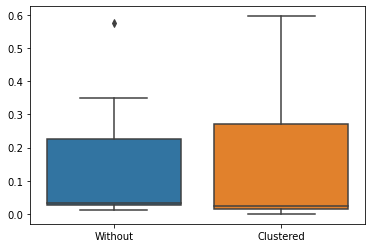

In [ ]:
ax = sns.boxplot(data=[acc_without, acc_coded])
ax.set(xticklabels=['Without', 'Clustered'])

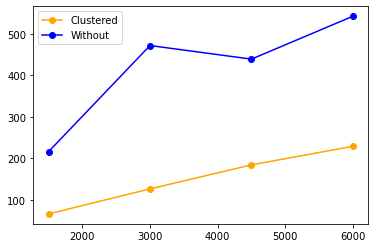

In [ ]:
plt.plot([1500, 3000, 4500, 6000], [65.7, 126.1, 184.1, 228.9], marker='o', color='orange', label='Clustered')
plt.plot([1500, 3000, 4500, 6000], [215.9, 472.1, 439.3, 542.8], marker='o', color='blue', label='Without')
plt.legend()

In [ ]:
for key in bn_dict:
    if key in bn_rename['V']:
        print(key)